In [1]:
from matplotlib import pyplot as plt
from itertools import product
import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy import signal, stats
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

In [2]:
def read_epochs(sub, desc):
    '''
    reads and concatenates epochs across runs
    '''
    layout = BIDSLayout(BIDS_ROOT, derivatives = True)
    run = lambda f: int(re.findall('run-(\w+)_', f)[0])
    fnames = layout.get(
        return_type = 'filename',
        subject = sub, 
        desc = desc
        )
    print(fnames)
    fnames.sort(key = run)
    epochs_all = [mne.read_epochs(f) for f in fnames]
    epochs = mne.concatenate_epochs(epochs_all)
    epochs = epochs.pick('eeg')
    return epochs

def compute_power_dB(evokeds):
    poststim = evokeds.compute_psd(tmin = 0., tmax = 0.2)
    baseline = evokeds.compute_psd(tmin = -0.2, tmax = 0.)
    power = 10 * np.log10(poststim.get_data() / baseline.get_data())
    power = np.squeeze(power)
    freqs = poststim.freqs
    return freqs, power

In [3]:
# # Look at FFR by target tone identity
# BIDS_ROOT = '../data/bids'
# layout = BIDSLayout(BIDS_ROOT, derivatives = True)
# subs = layout.get_subjects(scope = 'preprocess_ffr')
# subs.sort(key = int)
# spectrums = []

# condition_mapping = {
#     # two values: AB
#     # A: predictable is True, and target is 110 Hz then A = 1
#     # 	 predictable is True, and target is 150 Hz then mark A = 2
#     # 	 predictable is True, and target is 210 Hz then mark A = 3
#     # 	 predictable is False, and target is 110 Hz then mark A = 4
#     # 	 predictable is False, and target is 150 Hz then mark A = 5
#     # 	 predictable is False, and target is 210 Hz then mark A = 6
#     # B: if tone is 110 Hz then B = 1
#     #    if tone is 150 Hz then B = 2
#     #    if tone is 210 Hz then B = 3
#     '1': [True, 110], # [predictable, target tone]
#     '2': [True, 150],
#     '3': [True, 210],
#     '4': [False, 110],
#     '5': [False, 150],
#     '6': [False, 210],
# }

# tone_mapping = {'1': 110,
#                 '2': 150,
#                 '3': 210}

# for sub in subs:
#     if int(sub) < 10: # Drop early subs
#         continue
        
#     # Read epochs object
#     epochs = read_epochs(sub, 'forFFR')

#     # Get evoked potentials
#     conditions = list(epochs.event_id.keys())
#     evokeds = {c:epochs[c].average() for c in conditions}

#     # Iterate over conditions
#     for condition in conditions:
#         predictable = condition_mapping[condition[0]][0]
#         target = condition_mapping[condition[0]][1]
#         tone = tone_mapping[condition[1]]
        
#         # Compute power in dB
#         freqs, dB = compute_power_dB(evokeds[condition])
#         df = pd.DataFrame(
#             {'subject': int(sub),
#              'predictable': predictable,
#              'target': target,
#              'tone': tone,
#              'frequency': freqs,
#              'dB': dB
#             }
#         )
#         spectrums.append(df)
    
# # Create dataframe and save
# spectrums = pd.concat(spectrums)
# spectrums.to_csv('spectrums.csv', sep = '\t', index = False)

spectrums = pd.read_csv('spectrums.csv', sep = '\t')
intended_subs = set(range(2,42))
spectrums_subs = set(spectrums['subject'])
print(intended_subs - spectrums_subs)

{2, 3, 4, 5, 6, 7, 8, 9}


In [4]:
# Drop subjects with fewer than 80% trials
BADS = [33, 37]
for bad in BADS:
    spectrums = spectrums[spectrums['subject'] != bad]
np.unique(spectrums['subject'])

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

### FFR

In [5]:
palette_tab10 = sns.color_palette("tab10", 10)

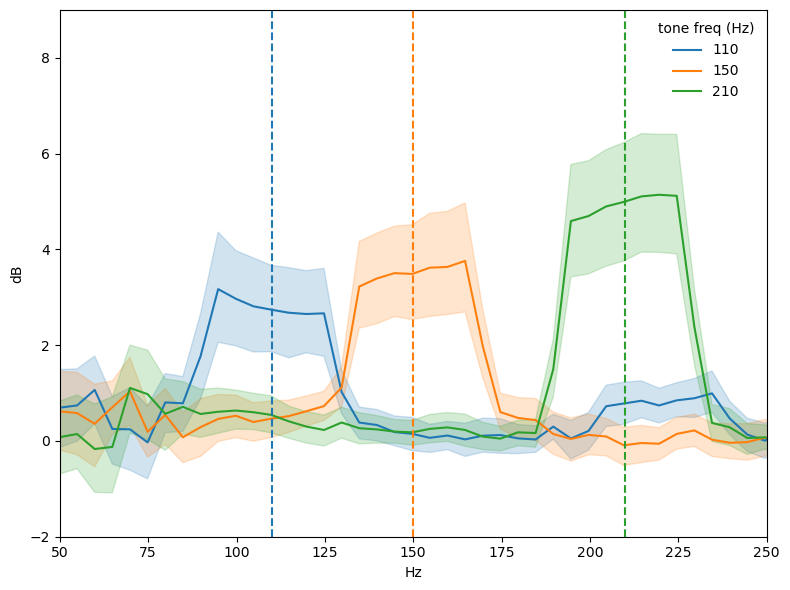

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
spectrums_sub = spectrums.groupby(['subject', 'frequency', 'tone'], as_index=False)['dB'].mean()
graph = sns.lineplot(data = spectrums_sub, x = "frequency", y = "dB", hue = "tone", palette = 'tab10', ax = ax)
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 250)
graph.set_ylim(-2, 9)
plt.legend(frameon=False, title = 'tone freq (Hz)')
plt.tight_layout()
plt.savefig('../figs/FFR.png')

### Main effect of target

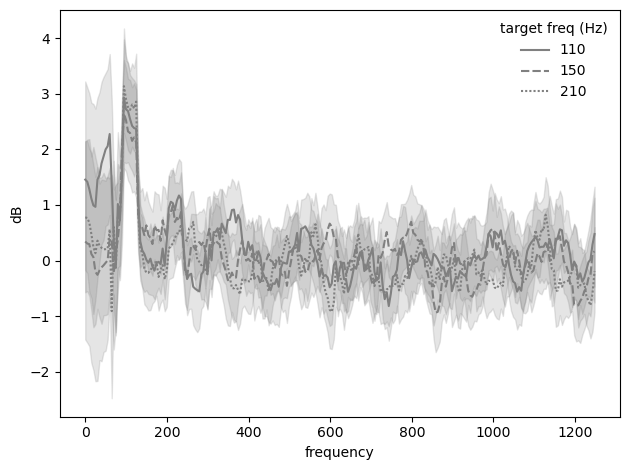

In [31]:
# just generate the legend
spectrums_110 = spectrums[spectrums.tone == 110]
graph = sns.lineplot(data = spectrums_110, x = "frequency", y = "dB", style = "target", color = 'grey')
plt.legend(frameon=False, title = 'target freq (Hz)')
plt.tight_layout()
plt.savefig('../figs/FFR-target-legend.png')

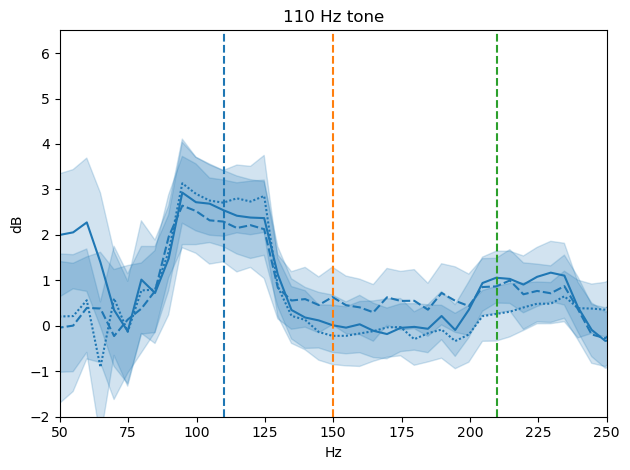

In [30]:
# fig, ax = plt.subplots(figsize=(8, 6))
spectrums_110 = spectrums[spectrums.tone == 110]
graph = sns.lineplot(data = spectrums_110, x = "frequency", y = "dB", style = "target", color = palette_tab10[0], legend = False)
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.set_title("110 Hz tone")
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 250)
graph.set_ylim(-2, 6.5)
plt.tight_layout()
plt.savefig('../figs/FFR-tone-1.png')

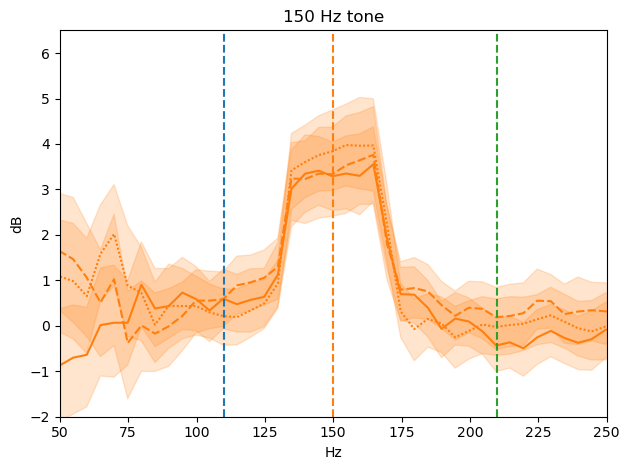

In [8]:
# fig, ax = plt.subplots(figsize=(8, 6))
spectrums_150 = spectrums[spectrums.tone == 150]
graph = sns.lineplot(data = spectrums_150, x = "frequency", y = "dB", style = "target", color = palette_tab10[1], legend = False)
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.set_title("150 Hz tone")
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 250)
graph.set_ylim(-2, 6.5)
plt.tight_layout()
plt.savefig('../figs/FFR-tone-2.png')

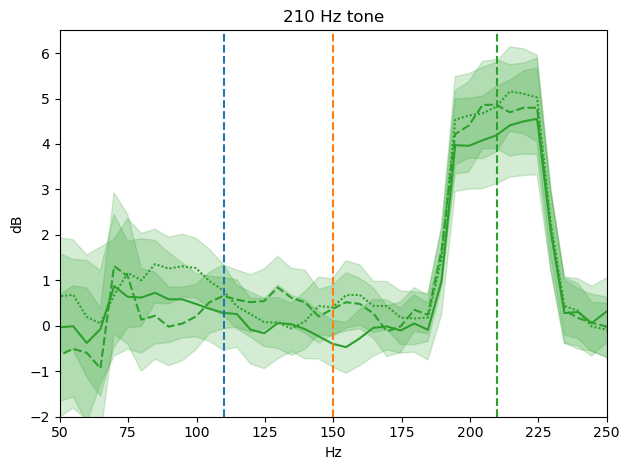

In [29]:
# fig, ax = plt.subplots(figsize=(8, 6))
spectrums_210 = spectrums[spectrums.tone == 210]
graph = sns.lineplot(data = spectrums_210, x = "frequency", y = "dB", style = "target", color = palette_tab10[2], legend = False)
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.set_title("210 Hz tone")
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 250)
graph.set_ylim(-2, 6.5)
plt.tight_layout()
plt.savefig('../figs/FFR-tone-3.png')

### Main effect of predictability

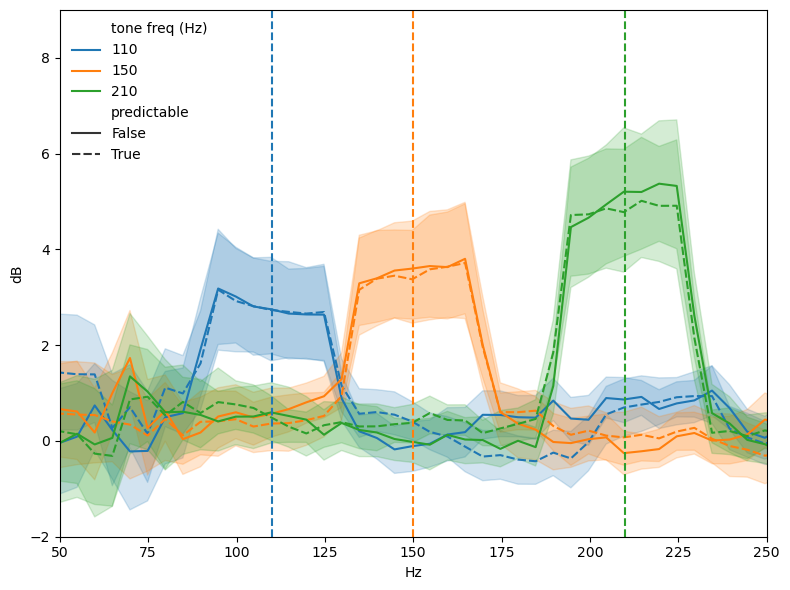

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
spectrums['tone freq (Hz)'] = spectrums.tone
spectrums_predictable = spectrums.groupby(['subject', 'frequency', 'tone freq (Hz)', 'predictable'], as_index=False)['dB'].mean()
graph = sns.lineplot(data = spectrums_predictable, x = "frequency", y = "dB", hue = "tone freq (Hz)", style = "predictable", palette = 'tab10', ax = ax)
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 250)
graph.set_ylim(-2, 9)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('../figs/FFR-by-predictability.png')

### By accuracy

In [11]:
# Add accuracy group to dataframe
spectrums = pd.read_csv('spectrums.csv', sep = '\t')
accuracy = pd.read_csv('accuracies.csv')
accuracy = accuracy.rename(columns = {'sub_num': 'subject'})
spectrums = spectrums.merge(accuracy, left_on = ["subject"], right_on = ["subject"])
spectrums

,subject,predictable,target,tone,frequency,dB,accuracy,accuracy_group
0,10,True,110,110,0.00000,-8.731832,0.979619,high
1,10,True,110,110,4.99002,-8.800200,0.979619,high
2,10,True,110,110,9.98004,-8.689376,0.979619,high
3,10,True,110,110,14.97006,-7.458321,0.979619,high
4,10,True,110,110,19.96008,-8.211036,0.979619,high
...,...,...,...,...,...,...,...,...
144571,41,False,210,210,1227.54491,-2.851024,0.957115,high
144572,41,False,210,210,1232.53493,-2.627593,0.957115,high
144573,41,False,210,210,1237.52495,-0.728880,0.957115,high
144574,41,False,210,210,1242.51497,-1.666897,0.957115,high


In [12]:
# Drop subjects with fewer than 80% trials
BADS = [33, 37]
for bad in BADS:
    spectrums = spectrums[spectrums['subject'] != bad]
np.unique(spectrums['subject'])

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

In [13]:
# Drop outliers
spectrums = spectrums[spectrums.subject != 18]
spectrums = spectrums[spectrums.subject != 38]

In [14]:
# Rename some columns
spectrums['accuracy'] = spectrums.accuracy_group
spectrums['tone freq (Hz)'] = spectrums.tone

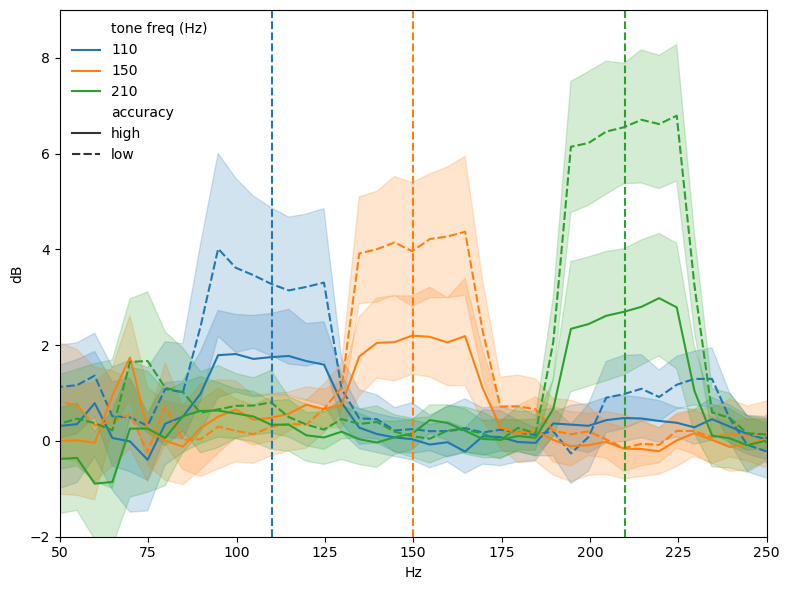

In [15]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
spectrums_accuracy = spectrums.groupby(['subject', 'frequency', 'tone freq (Hz)', 'accuracy_group'], as_index=False)['dB'].mean()
spectrums_accuracy['accuracy'] = spectrums_accuracy.accuracy_group
graph = sns.lineplot(data = spectrums_accuracy, x = "frequency", y = "dB", hue = "tone freq (Hz)", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 250)
graph.set_ylim(-2, 9)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('../figs/FFR-by-accuracy.png')

In [16]:
# Tests
spectrums_110 = spectrums[spectrums.tone == 110]
spectrums_110 = spectrums_110[(spectrums.frequency < 111) & (spectrums.frequency > 109)]
spectrums_110 = spectrums_110.groupby(['subject', 'accuracy_group'], as_index=False)['dB'].mean()
print(stats.ttest_ind(spectrums_110.dB[spectrums_110.accuracy_group == 'low'], spectrums_110.dB[spectrums_110.accuracy_group == 'high'], alternative = 'greater'))

spectrums_150 = spectrums[spectrums.tone == 150]
spectrums_150 = spectrums_150[(spectrums.frequency < 151) & (spectrums.frequency > 149)]
spectrums_150 = spectrums_150.groupby(['subject', 'accuracy_group'], as_index=False)['dB'].mean()
print(stats.ttest_ind(spectrums_150.dB[spectrums_150.accuracy_group == 'low'], spectrums_150.dB[spectrums_150.accuracy_group == 'high'], alternative = 'greater'))

spectrums_210 = spectrums[spectrums.tone == 210]
spectrums_210 = spectrums_210[(spectrums.frequency < 210) & (spectrums.frequency > 209)]
spectrums_210 = spectrums_210.groupby(['subject', 'accuracy_group'], as_index=False)['dB'].mean()
print(stats.ttest_ind(spectrums_210.dB[spectrums_210.accuracy_group == 'low'], spectrums_210.dB[spectrums_210.accuracy_group == 'high'], alternative = 'greater'))

TtestResult(statistic=1.5885216307141283, pvalue=0.06212819775186152, df=26.0)
TtestResult(statistic=2.0729636003081757, pvalue=0.024112138271775628, df=26.0)
TtestResult(statistic=3.8271271279842876, pvalue=0.00036632326217360975, df=26.0)


/scratch/local/jobs/21926946/ipykernel_371078/3353086728.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spectrums_110 = spectrums_110[(spectrums.frequency < 111) & (spectrums.frequency > 109)]
/scratch/local/jobs/21926946/ipykernel_371078/3353086728.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spectrums_150 = spectrums_150[(spectrums.frequency < 151) & (spectrums.frequency > 149)]
/scratch/local/jobs/21926946/ipykernel_371078/3353086728.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spectrums_210 = spectrums_210[(spectrums.frequency < 210) & (spectrums.frequency > 209)]


<Axes: xlabel='accuracy_group', ylabel='dB'>

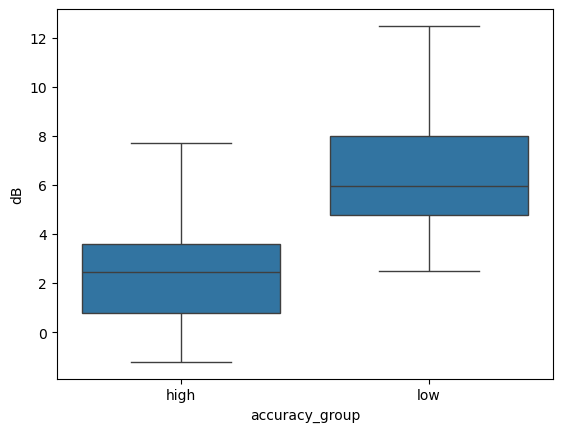

In [17]:
sns.boxplot(spectrums_210, x = 'accuracy_group', y = 'dB')

(50.0, 250.0)

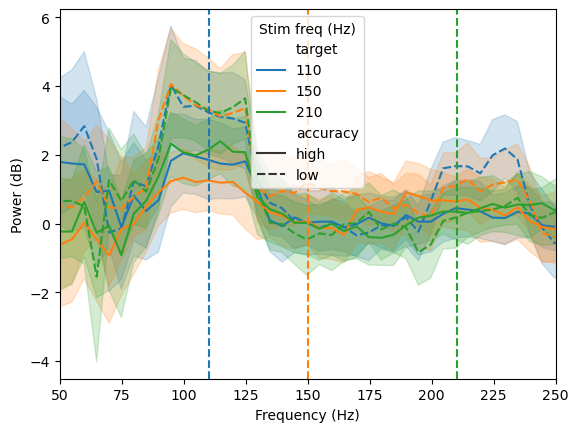

In [18]:
# fig, ax = plt.subplots(figsize=(8, 6))
spectrums_110 = spectrums[spectrums.tone == 110]
graph = sns.lineplot(data = spectrums_110, x = "frequency", y = "dB", hue = "target", style = "accuracy", palette = 'tab10')
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.legend(title = 'Stim freq (Hz)')
graph.set_ylabel("Power (dB)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(50, 250)

(50.0, 250.0)

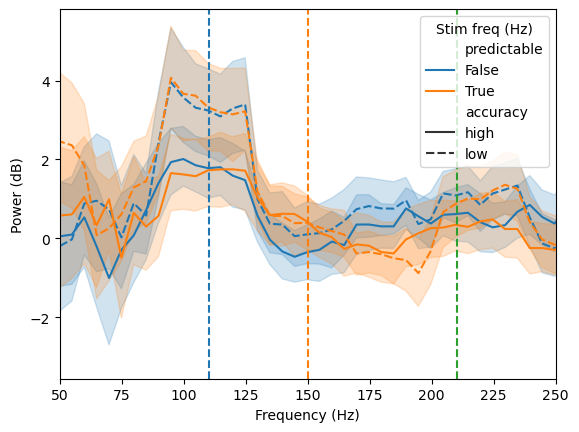

In [19]:
# fig, ax = plt.subplots(figsize=(8, 6))
spectrums_110 = spectrums[spectrums.tone == 110]
graph = sns.lineplot(data = spectrums_110, x = "frequency", y = "dB", hue = "predictable", style = "accuracy", palette = 'tab10')
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.legend(title = 'Stim freq (Hz)')
graph.set_ylabel("Power (dB)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(50, 250)

(50.0, 250.0)

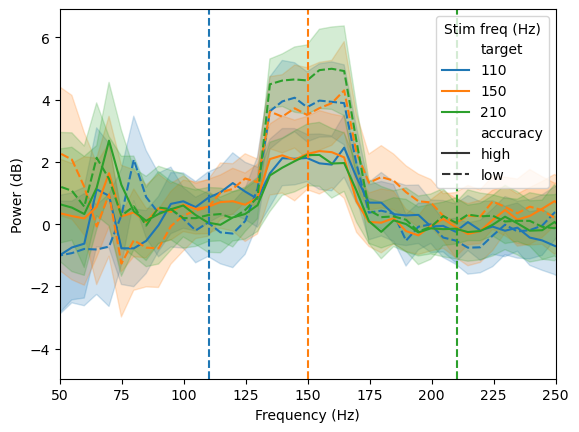

In [20]:
# fig, ax = plt.subplots(figsize=(8, 6))
spectrums_150 = spectrums[spectrums.tone == 150]
graph = sns.lineplot(data = spectrums_150, x = "frequency", y = "dB", hue = "target", style = "accuracy", palette = 'tab10')
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.legend(title = 'Stim freq (Hz)')
graph.set_ylabel("Power (dB)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(50, 250)

(50.0, 250.0)

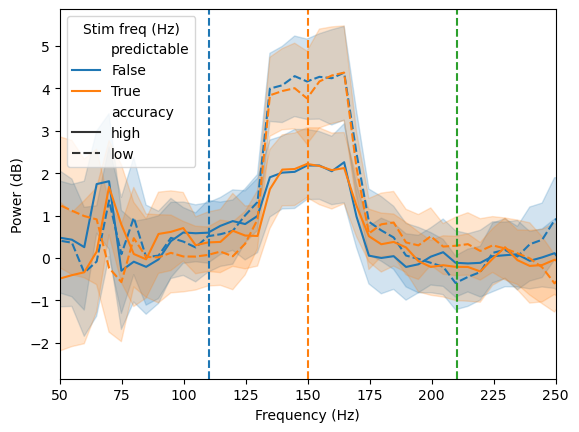

In [21]:
# fig, ax = plt.subplots(figsize=(8, 6))
spectrums_150 = spectrums[spectrums.tone == 150]
graph = sns.lineplot(data = spectrums_150, x = "frequency", y = "dB", hue = "predictable", style = "accuracy", palette = 'tab10')
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.legend(title = 'Stim freq (Hz)')
graph.set_ylabel("Power (dB)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(50, 250)

(50.0, 250.0)

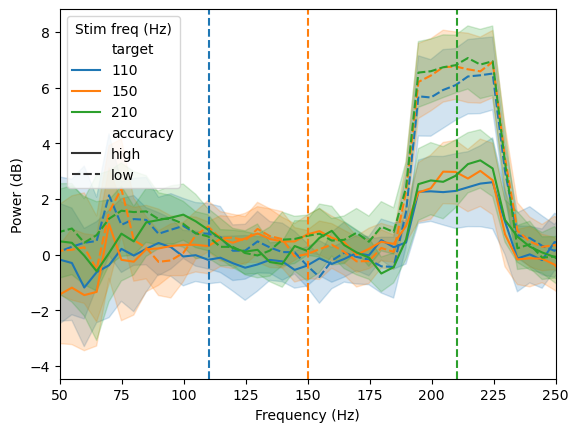

In [22]:
# fig, ax = plt.subplots(figsize=(8, 6))
spectrums_210 = spectrums[spectrums.tone == 210]
graph = sns.lineplot(data = spectrums_210, x = "frequency", y = "dB", hue = "target", style = "accuracy", palette = 'tab10')
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.legend(title = 'Stim freq (Hz)')
graph.set_ylabel("Power (dB)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(50, 250)

(50.0, 250.0)

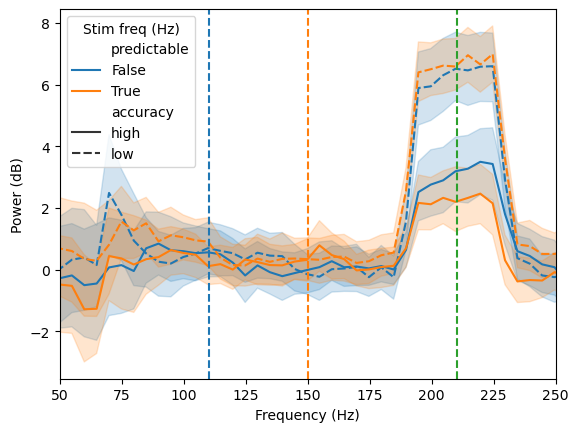

In [23]:
# fig, ax = plt.subplots(figsize=(8, 6))
spectrums_210 = spectrums[spectrums.tone == 210]
graph = sns.lineplot(data = spectrums_210, x = "frequency", y = "dB", hue = "predictable", style = "accuracy", palette = 'tab10')
graph.axvline(110, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(150, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(210, linestyle = 'dashed', color = palette_tab10[2])
graph.legend(title = 'Stim freq (Hz)')
graph.set_ylabel("Power (dB)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(50, 250)

### Stats

In [24]:
stim_freq = 110

# select Fourier frequency nearest to stimulus frequency 
idx = np.abs(spectrums.frequency - stim_freq).argmin()
hz = spectrums.frequency[idx]
power_f0 = spectrums[spectrums.frequency == hz]
power_f0 = power_f0[power_f0.tone == stim_freq]
power_f0 = power_f0[power_f0.target == stim_freq]

# Compute t-test for predictability
ttest = stats.ttest_ind(power_f0.dB[power_f0.predictable == True], power_f0.dB[power_f0.predictable == False])
print(ttest)

# Compute t-test for accuracy
ttest = stats.ttest_ind(power_f0.dB[power_f0.accuracy_group == 'low'], power_f0.dB[power_f0.accuracy_group == 'high'], alternative = 'greater')
print(ttest)

TtestResult(statistic=0.09888735958225085, pvalue=0.9215938844904541, df=54.0)
TtestResult(statistic=1.5653426471454812, pvalue=0.061672281121856604, df=54.0)


In [25]:
stim_freq = 150

# select Fourier frequency nearest to stimulus frequency 
idx = np.abs(spectrums.frequency - stim_freq).argmin()
hz = spectrums.frequency[idx]
power_f0 = spectrums[spectrums.frequency == hz]
power_f0 = power_f0[power_f0.tone == stim_freq]
power_f0 = power_f0[power_f0.target == stim_freq]

# Compute t-test
ttest = stats.ttest_ind(power_f0.dB[power_f0.predictable == True], power_f0.dB[power_f0.predictable == False])
print(ttest)

# Compute t-test for accuracy
ttest = stats.ttest_ind(power_f0.dB[power_f0.accuracy_group == 'low'], power_f0.dB[power_f0.accuracy_group == 'high'], alternative = 'greater')
print(ttest)

TtestResult(statistic=-0.8091309758458709, pvalue=0.42199068638973536, df=54.0)
TtestResult(statistic=1.2727779202061216, pvalue=0.10427479954013553, df=54.0)


In [26]:
stim_freq = 210

# select Fourier frequency nearest to stimulus frequency 
idx = np.abs(spectrums.frequency - stim_freq).argmin()
hz = spectrums.frequency[idx]
power_f0 = spectrums[spectrums.frequency == hz]
power_f0 = power_f0[power_f0.tone == stim_freq]
power_f0 = power_f0[power_f0.target == stim_freq]

# Compute t-test
ttest = stats.ttest_ind(power_f0.dB[power_f0.predictable == True], power_f0.dB[power_f0.predictable == False])
print(ttest)

# Compute t-test for accuracy
ttest = stats.ttest_ind(power_f0.dB[power_f0.accuracy_group == 'low'], power_f0.dB[power_f0.accuracy_group == 'high'], alternative = 'greater')
print(ttest)

TtestResult(statistic=-0.026882438610962837, pvalue=0.9786526022347715, df=54.0)
TtestResult(statistic=4.703216757595963, pvalue=9.076499255256109e-06, df=54.0)


### Calculate diff

In [27]:
stim_freq = 150
stim_spectrum = spectrums[spectrums.tone == stim_freq]
stim_spectrum = stim_spectrum[stim_spectrum.target == stim_freq]
diffs = []

SUBS = np.unique(stim_spectrum.subject)
for sub in SUBS:
    sub_stim_spectrum = stim_spectrum[stim_spectrum.subject != sub]

    # select Fourier frequency nearest to stimulus frequency 
    idx = np.abs(spectrums.frequency - stim_freq).argmin()
    hz = spectrums.frequency[idx]
    power_f0 = sub_stim_spectrum[sub_stim_spectrum.frequency == hz]
    power_f0 = power_f0[power_f0.tone == stim_freq]
    power_f0 = power_f0[power_f0.target == stim_freq]

    # Compute mean at stim freq
    power_f0_mean = power_f0.groupby('predictable').mean()

    # Compute differences between means at stim freq
    power_f0_mean = power_f0_mean.reset_index()
    predictable = list(power_f0_mean.dB[power_f0_mean.predictable == True])[0]
    random = list(power_f0_mean.dB[power_f0_mean.predictable == False])[0]
    diff = random - predictable
    print(f'drop sub {sub}, diff = {diff}')

    # Data frame
    df = pd.DataFrame({'sub': [sub],
        'diff': [diff]})
    diffs.append(df)

diffs = pd.concat(diffs)
diffs
    

TypeError: agg function failed [how->mean,dtype->object]

### Calculate mean

In [ ]:
power_f0

In [ ]:
from scipy import stats

stim_freq = 150
stim_spectrum = spectrums[spectrums.tone == stim_freq]
stim_spectrum = stim_spectrum[stim_spectrum.target == stim_freq]
diffs = []

SUBS = np.unique(stim_spectrum.subject)
for sub in SUBS:
    sub_stim_spectrum = stim_spectrum[stim_spectrum.subject != sub]

    # select Fourier frequency nearest to stimulus frequency 
    idx = np.abs(spectrums.frequency - stim_freq).argmin()
    hz = spectrums.frequency[idx]
    power_f0 = sub_stim_spectrum[sub_stim_spectrum.frequency == hz]
    power_f0 = power_f0[power_f0.tone == stim_freq]
    power_f0 = power_f0[power_f0.target == stim_freq]

    # Compute mean at stim freq
    power_f0_mean = power_f0.groupby('predictable').mean()

    # Compute differences between means at stim freq
    power_f0_mean = power_f0_mean.reset_index()
    predictable = list(power_f0_mean.dB[power_f0_mean.predictable == True])[0]
    random = list(power_f0_mean.dB[power_f0_mean.predictable == False])[0]
    diff = random - predictable
    print(f'drop sub {sub}, diff = {diff}')

    # Compute t-test
    ttest = stats.ttest_ind(power_f0.dB[power_f0.predictable == True], power_f0.dB[power_f0.predictable == False])

    # Data frame
    df = pd.DataFrame({
        'sub': [sub],
        'predictable': [predictable],
        'random': [random],
        'diff': [diff],
        't': [ttest.statistic],
        'p': [ttest.pvalue]
    })
    diffs.append(df)

diffs = pd.concat(diffs)
diffs


In [ ]:
diffs.sort_values(by = ['p'])

In [ ]:
ttest.statistic

In [ ]:
diffs

In [ ]:
list(predictable)